In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import requests
import json
import sys
import tempfile
import seaborn as sns

In [3]:
load_dotenv("../.env")

True

In [4]:
# create authorization headers
headers = {
    'Authorization': 'Bearer ' + os.getenv("API_SECRET_KEY")
}


df = pd.read_json(r'http://54.236.48.243:4000/api/dataset', storage_options=headers)

In [5]:
unNeededColumns = ['_id', '_date', '_user', 'bm_HR_max', 'bm_act_steps']
df.drop(unNeededColumns, axis=1, inplace=True)

dfClean = df.dropna()

X = dfClean.iloc[:, -3:]

# Define targets
targets = {
    'fm_avg_trk_time': dfClean.iloc[:, 0],
    'fm_accuracy': dfClean.iloc[:, 1],
    'vx_avg_res_time': dfClean.iloc[:, 2],
    'vx_shot_accuracy': dfClean.iloc[:, 3],
    'vx_trg_accuracy': dfClean.iloc[:, 4],
    'au_avg_res_time': dfClean.iloc[:, 5]
}


In [6]:
# Scale targets
scaler = StandardScaler()
scaled_targets = {name: scaler.fit_transform(target.values.reshape(-1, 1)) for name, target in targets.items()}

# Split the data
splits = {name: train_test_split(X, scaled, test_size=0.2, random_state=4217) for name, scaled in scaled_targets.items()}

In [7]:
 # Model configurations
models = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()), ('clf', LinearRegression())]),
    'SVR': Pipeline([('scaler', StandardScaler()), ('clf', SVR())]),
    'Random Forest': Pipeline([('scaler', StandardScaler()), ('clf', RandomForestRegressor())]),
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsRegressor())])
}

param_grids = {
    'Linear Regression': {'clf__fit_intercept': [True, False]},
    'SVR': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']},
    'Random Forest': {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20]},
    'KNN': {'clf__n_neighbors': [3, 5, 7], 'clf__weights': ['uniform', 'distance']}
}

In [8]:
results = []
best_models = {}
plot_paths = {}

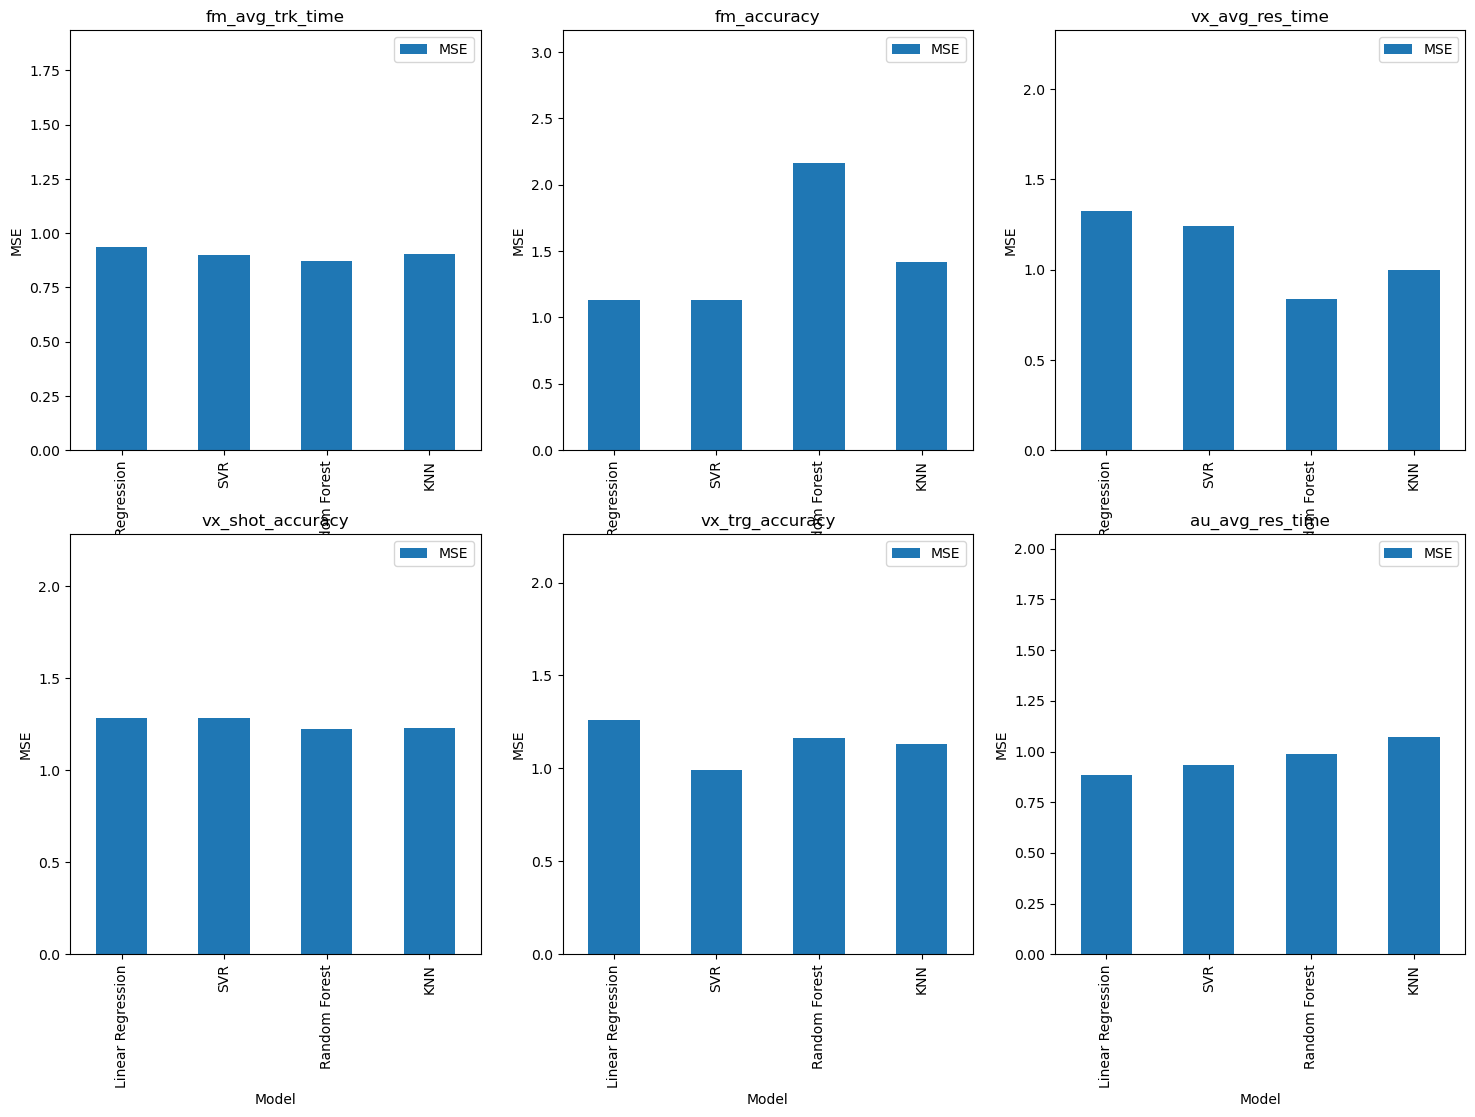

In [9]:
# Prepare a plot with subplots for model performance comparison
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()  # Flatten to easily index them

for i, (name, (X_train, X_test, y_train, y_test)) in enumerate(splits.items()):
    model_performance = []
    min_mse = float('inf') 
    best_model_info = None

    for model_name, pipe in models.items():
        grid_search = GridSearchCV(pipe, param_grids[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train.ravel())
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        mse = mean_squared_error(y_test.ravel(), y_pred)
        results.append({'Variable': name, 'Model': model_name, 'MSE': mse})
        model_performance.append((model_name, mse))
        
        if mse < min_mse:
            min_mse = mse
            best_model_info = (best_model, model_name, mse)
    
    best_models[name] = best_model_info

    # Plot model performance on the corresponding subplot
    performance_df = pd.DataFrame(model_performance, columns=['Model', 'MSE'])
    performance_df.set_index('Model').plot(kind='bar', ax=axes[i], title=name)
    axes[i].set_ylabel('MSE')
    axes[i].set_ylim([0, max(performance_df['MSE']) + 1])  # Adjust Y-limits for better comparison

In [10]:
# describe the best models for each variable
for name, (model, model_name, mse) in best_models.items():
    print(f'Best model for {name}: {model_name} with MSE: {mse}')
    plot_paths[name] = os.path.join(tempfile.gettempdir(), f'{name}_plot.png')
    sns.scatterplot(x=model.predict(splits[name][1]).ravel(), y=splits[name][3].ravel())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name)
    plt.savefig(plot_paths[name])
    plt.clf()
    

Best model for fm_avg_trk_time: Random Forest with MSE: 0.870114178233833
Best model for fm_accuracy: Linear Regression with MSE: 1.1277638453966927
Best model for vx_avg_res_time: Random Forest with MSE: 0.8388311285206633
Best model for vx_shot_accuracy: Random Forest with MSE: 1.2245289722711996
Best model for vx_trg_accuracy: SVR with MSE: 0.992555096863918
Best model for au_avg_res_time: Linear Regression with MSE: 0.8833858885067568


<Figure size 640x480 with 0 Axes>

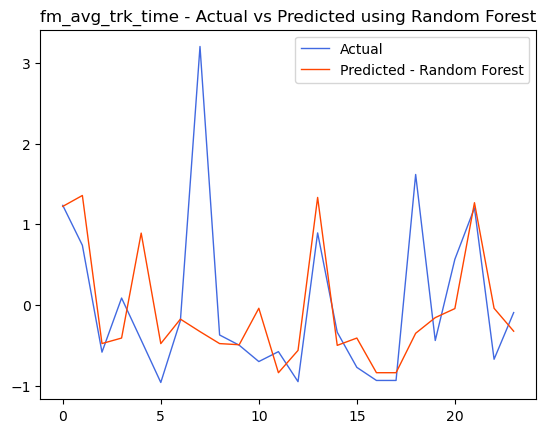

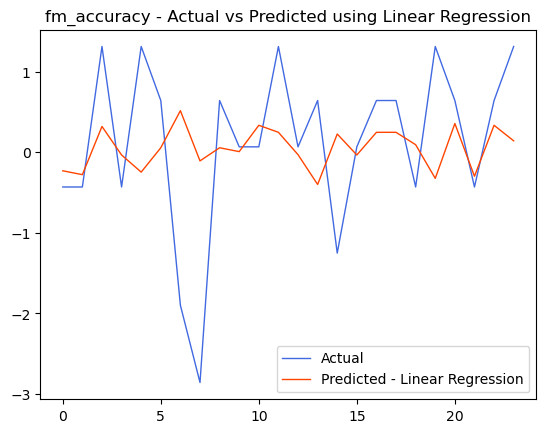

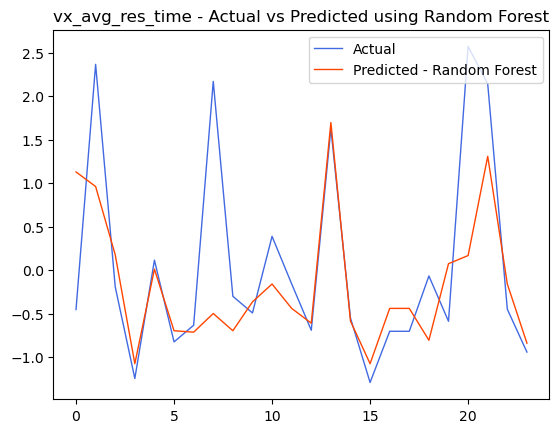

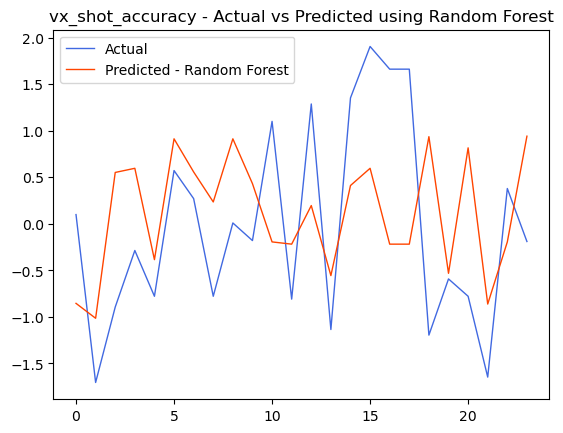

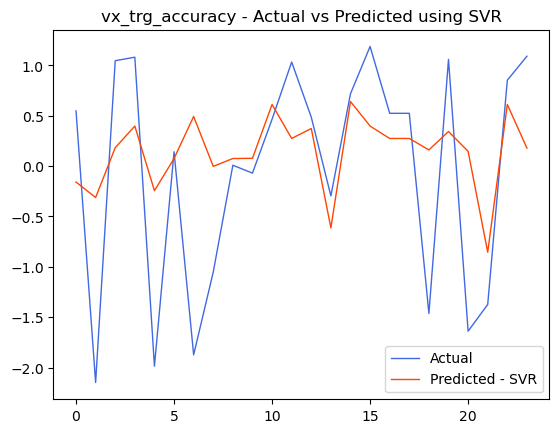

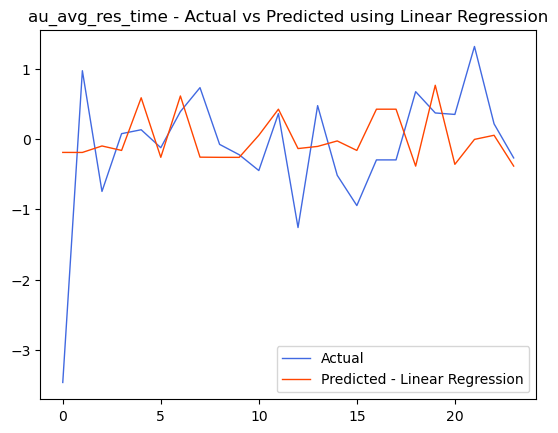

In [11]:
for name, (best_model, model_name, _) in best_models.items():
        _, X_test, _, y_test = splits[name]
        y_pred = best_model.predict(X_test)
        plt.rcParams.update({'figure.facecolor': 'white'})    
        plt.figure()
        plt.plot(range(len(y_test)), y_test.ravel(), label='Actual', linestyle='-',color='royalblue' ,linewidth=1)
        plt.plot(range(len(y_pred)), y_pred, label=f'Predicted - {model_name}', linestyle='-', color='orangered' ,linewidth=1)
        plt.title(f'{name} - Actual vs Predicted using {model_name}')
      
        plt.legend()
        plt.show()



In [12]:
class_abbreviations = {
    "SupportVectorRegressor": "SVR",
    "RandomForestRegressor": "RFR",
    "KNeighborsRegressor": "KNR",
    "LinearRegression": "LR"
}

In [13]:
# Set default style
plt.style.use('default')

def plot_actual_vs_predicted(X, y, best_model, target_name):
    y_pred = best_model.predict(X)
    plt.figure()
    plt.plot(range(len(y)), y, label='Actual', linestyle='-', color='black', linewidth=1)
    plt.plot(range(len(y_pred)), y_pred, label=f'Predicted - {target_name}', linestyle='--', color='gray', linewidth=1)
    
    # Get the full class name from the best model
    full_class_name = best_model.named_steps["clf"].__class__.__name__
    # Get the abbreviated class name using the dictionary
    abbreviated_class_name = class_abbreviations.get(full_class_name, full_class_name)
    
    plt.title(f'{target_name} - Actual vs Predicted using {abbreviated_class_name}')
    plt.legend()
    plt.show()

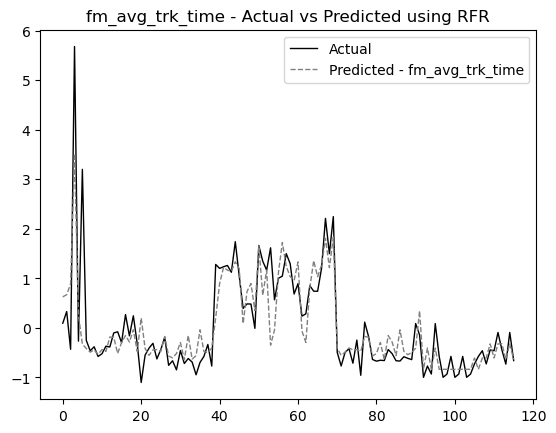

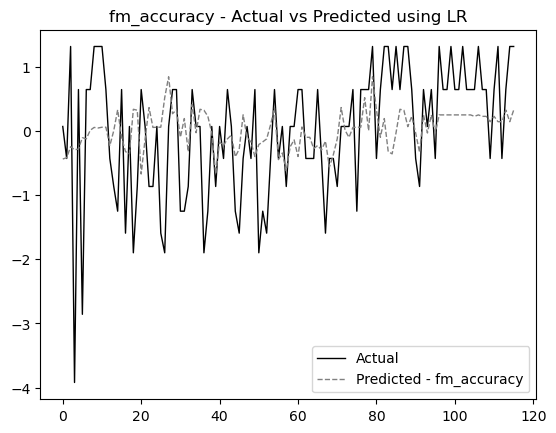

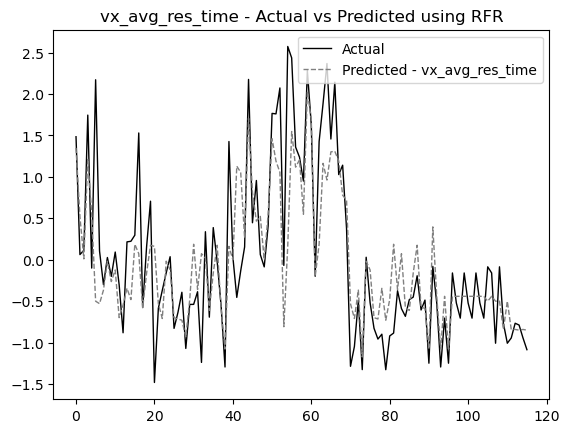

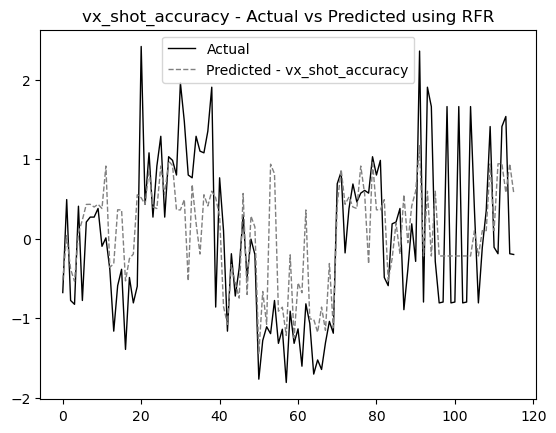

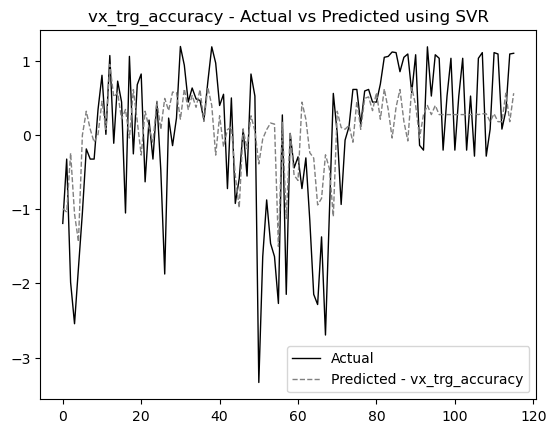

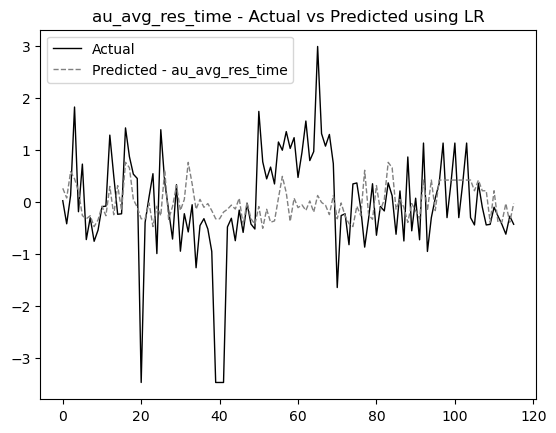

In [14]:
for target_name, scaled_target in scaled_targets.items():
    # Get the corresponding best model for the target
    best_model_info = best_models[target_name]
    best_model = best_model_info[0]
    # Plot actual vs predicted values
    plot_actual_vs_predicted(X, scaled_target, best_model, target_name)


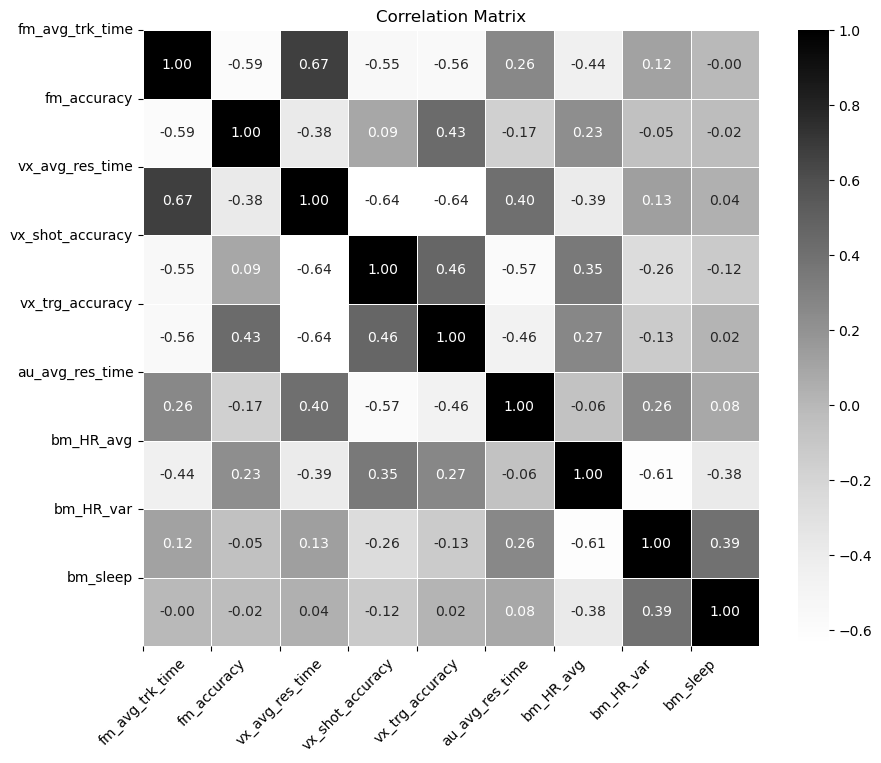

In [15]:
correlation_matrix = dfClean.corr(method='pearson')
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Greys', square=True, linewidths=.5)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

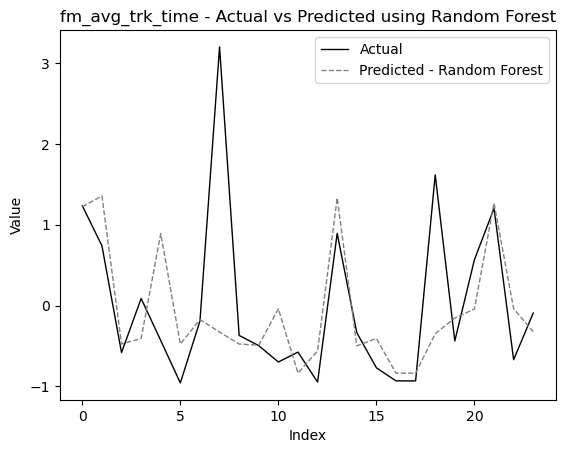

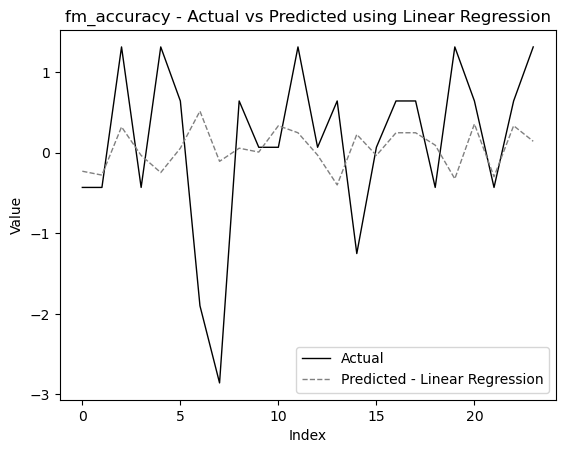

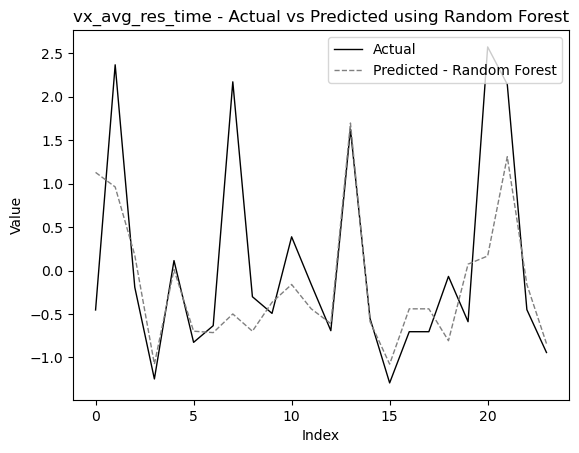

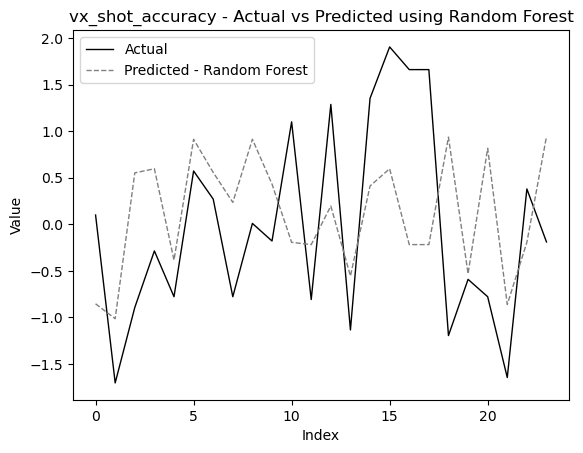

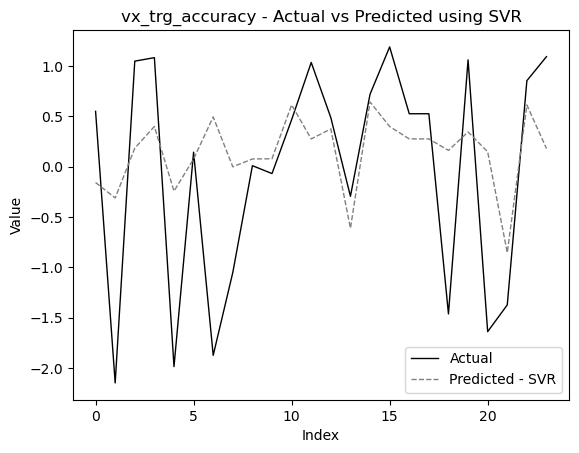

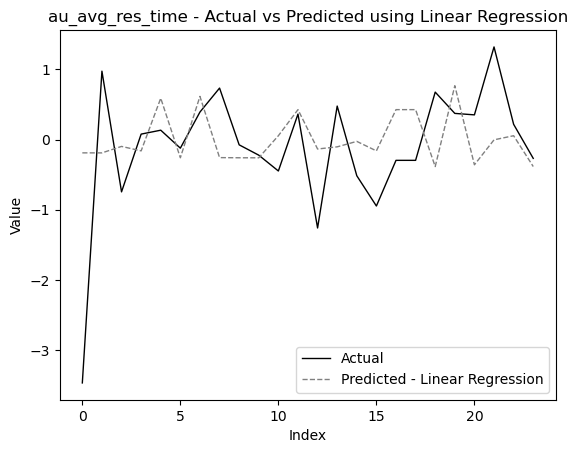

In [16]:
# for name, (best_model, model_name, _) in best_models.items():
#         _, X_test, _, y_test = splits[name]
#         y_pred = best_model.predict(X_test)
#         plt.rcParams.update({'figure.facecolor': 'white'})    
#         plt.figure()
#         plt.plot(range(len(y_test)), y_test.ravel(), label='Actual', linestyle='-',color='black' ,linewidth=1)
#         plt.plot(range(len(y_pred)), y_pred, label=f'Predicted - {model_name}', linestyle='--', color='gray' ,linewidth=1)
#         plt.title(f'{name} - Actual vs Predicted using {model_name}')
#         plt.xlabel('Index')
#         plt.ylabel('Value')
#         plt.legend()
#         plt.show()

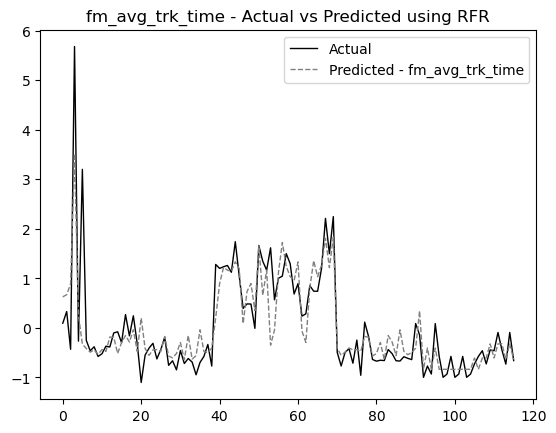

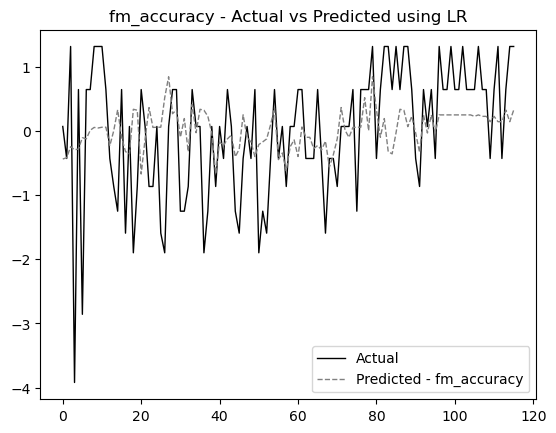

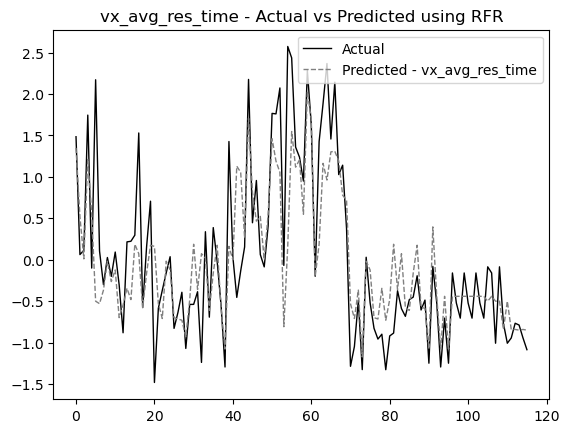

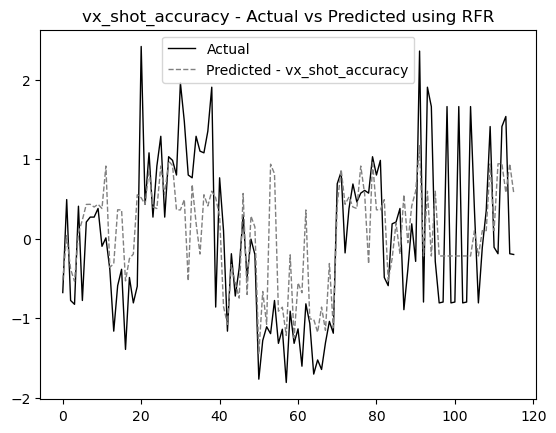

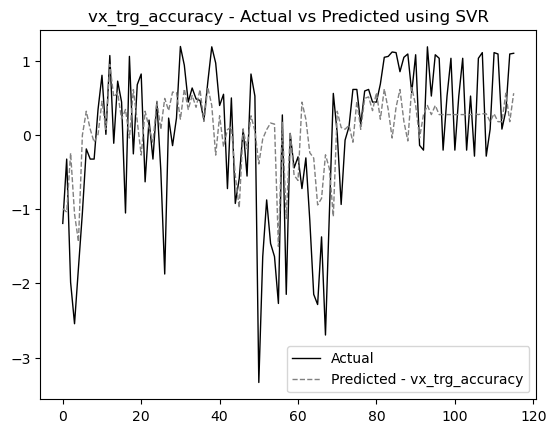

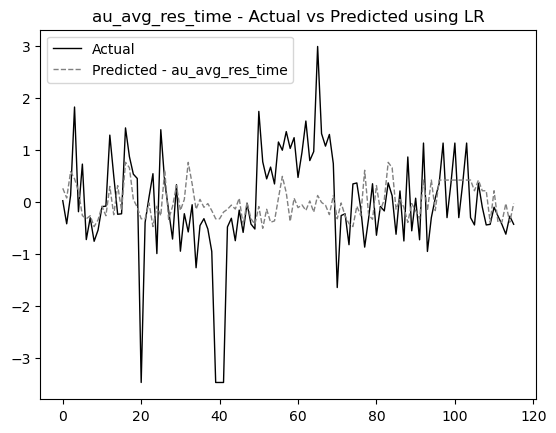

In [17]:
# Iterate through each target
for target_name, scaled_target in scaled_targets.items():
    # Get the corresponding best model for the target
    best_model_info = best_models[target_name]
    best_model = best_model_info[0]
    # Plot actual vs predicted values
    plot_actual_vs_predicted(X, scaled_target, best_model, target_name)

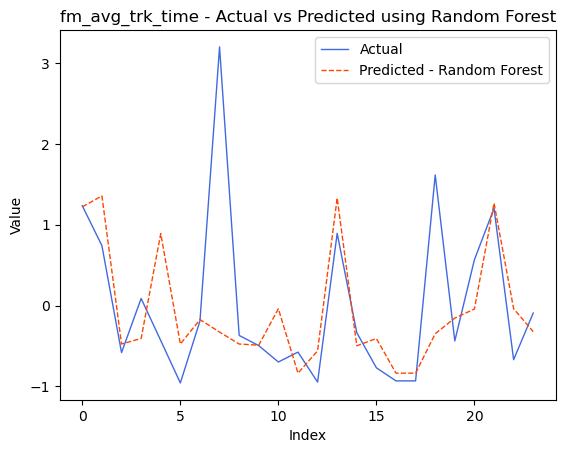

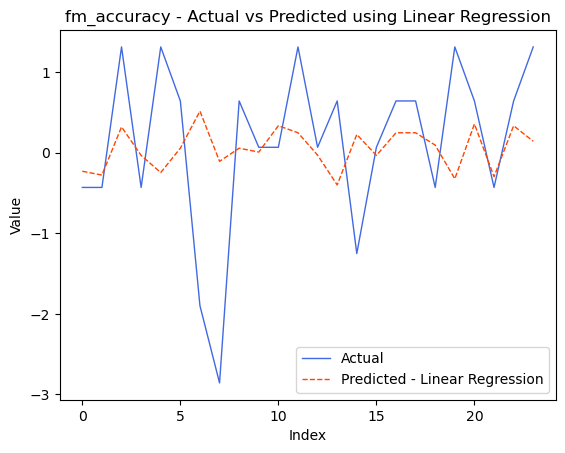

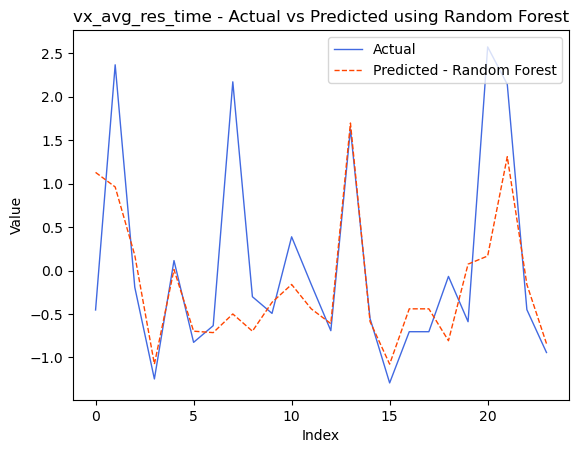

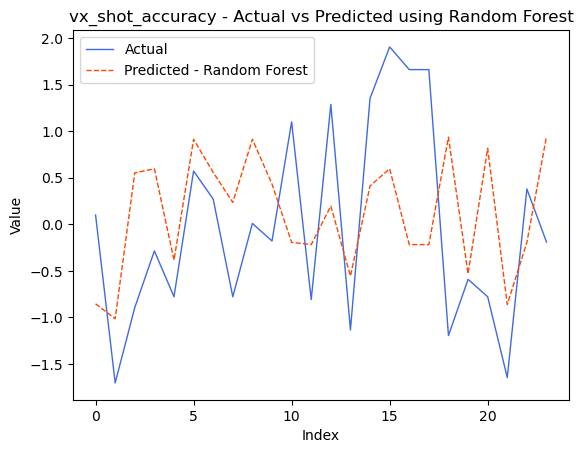

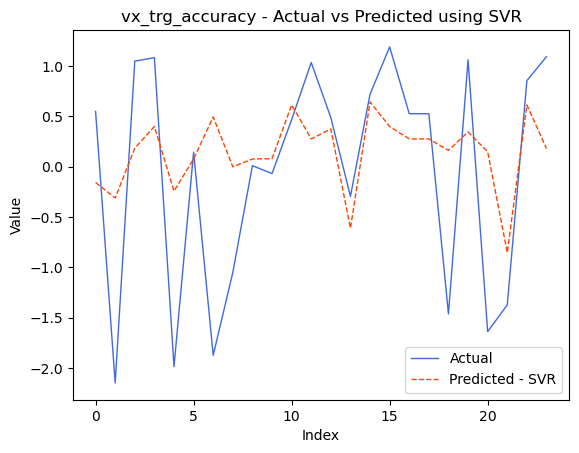

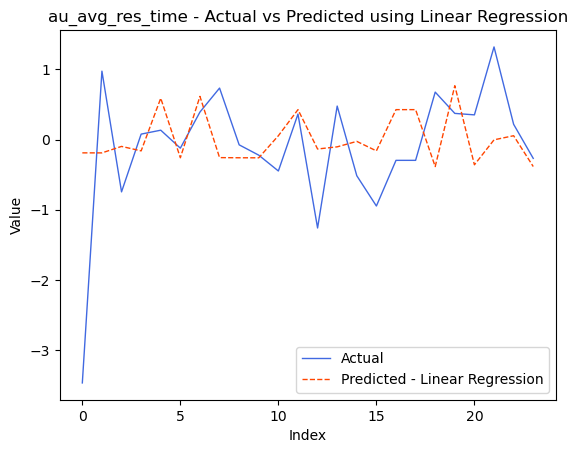

In [22]:
for name, (best_model, model_name, _) in best_models.items():
        _, X_test, _, y_test = splits[name]
        y_pred = best_model.predict(X_test)
        plt.rcParams.update({'figure.facecolor': 'white'})    
        plt.figure()
        plt.plot(range(len(y_test)), y_test.ravel(), label='Actual', linestyle='-',color='royalblue' ,linewidth=1)
        plt.plot(range(len(y_pred)), y_pred, label=f'Predicted - {model_name}', linestyle='--', color='orangered' ,linewidth=1)
        plt.title(f'{name} - Actual vs Predicted using {model_name}')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

In [24]:
# Set default style
plt.style.use('default')

def plot_actual_vs_predicted(X, y, best_model, target_name):
    y_pred = best_model.predict(X)
    plt.figure()
    plt.plot(range(len(y)), y, label='Actual', linestyle='-', color='royalblue', linewidth=1)
    plt.plot(range(len(y_pred)), y_pred, label=f'Predicted - {target_name}', linestyle='--', color='orangered', linewidth=1)
    
    # Get the full class name from the best model
    full_class_name = best_model.named_steps["clf"].__class__.__name__
    # Get the abbreviated class name using the dictionary
    abbreviated_class_name = class_abbreviations.get(full_class_name, full_class_name)
    
    plt.title(f'{target_name} - Actual vs Predicted using {abbreviated_class_name}')
    plt.legend()
    plt.show()

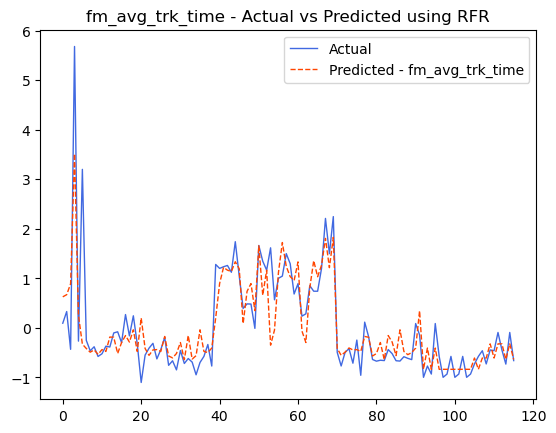

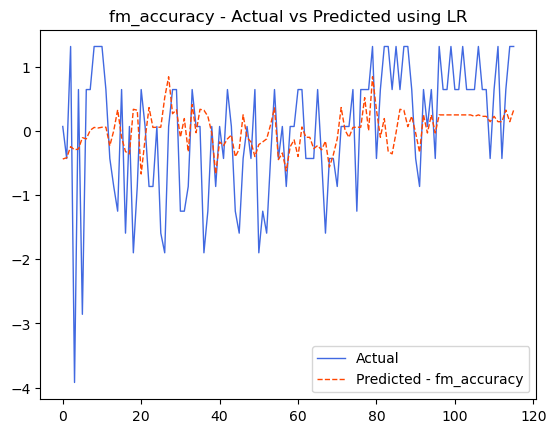

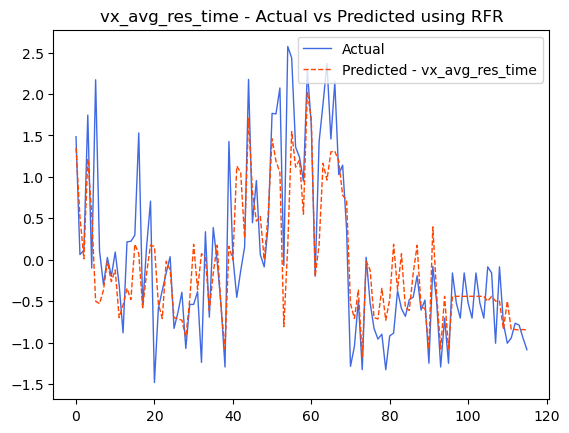

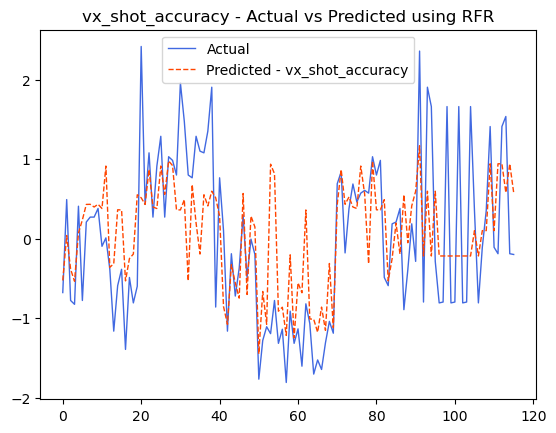

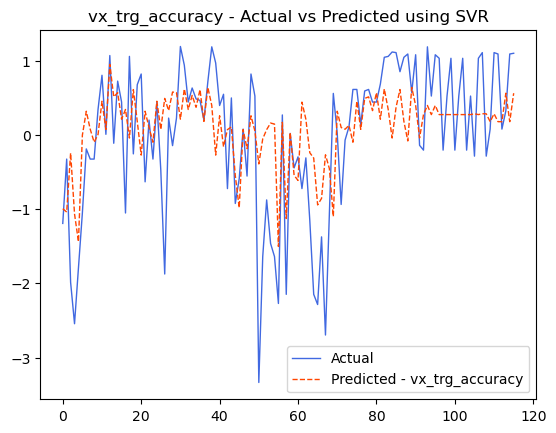

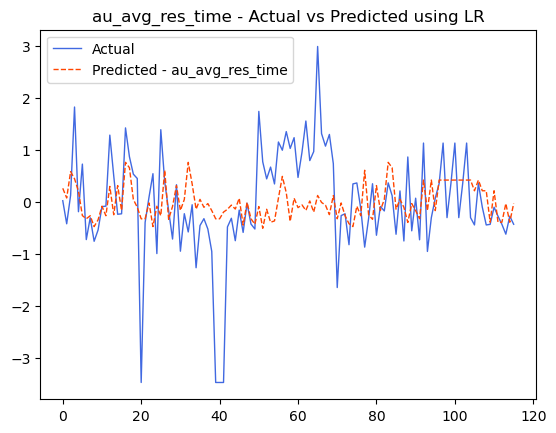

In [25]:
# Iterate through each target
for target_name, scaled_target in scaled_targets.items():
    # Get the corresponding best model for the target
    best_model_info = best_models[target_name]
    best_model = best_model_info[0]
    # Plot actual vs predicted values
    plot_actual_vs_predicted(X, scaled_target, best_model, target_name)